<a href="https://colab.research.google.com/github/petre001/Demo/blob/main/finalexam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [210]:
NAME = "Jeffrey Petrella"
COLLABORATORS = "None"

In [211]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


---

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Predicting Demand for Washington D.C.'s Bike Share System

## Background
You have just been hired as the first data scientist working for Capital Bikeshare, the organization which runs the Washington D.C. bike sharing system. The first major project they have asked you to work on is to build a model to predict demand for the shared bikes in the system for each hour of each day.  

Having an accurate understanding of the expected demand is critical to the successful operation of Capital Bikeshare.  If they underestimate demand and have too few bikes available, potential users of the system are not able to find a bike to use and so get upset and are less likely to use the system in the future.  If they overestimate by too much, they end up with too many bikes sitting around not being used.  In the real-world, one of the things that makes this challenging is that they have to predict demand for each pick-up hub location.  To keep things simple for our final, we will focus on predicting aggregate demand.

Our task in this final is to build the pipeline to convert raw data into features to use in a ML model. The model itself that you will use has already been set up for you (a linear regression model) and **you cannot change the model**, only the data pipeline.

## Data
You have been given two csv files of data to use in your analysis.  The first file ("2011-2012_bikes.csv") contains historical demand data from the past two years of operation. The dataset contains the following columns:
- dteday : date 
- hr : hour (0 to 23) 
- cnt: count of total rental bikes 

The second file ("2011-2012_weather_messy.csv") contains weather information for the same time period.  This dataset contains the following columns:  
- dteday : date 
- hr : hour (0 to 23) 
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp : Temperature in Celsius
- atemp: Feels-like temperature in Celsius
- hum: Humidity
- windspeed: Wind speed

In [212]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'2011-2012_bikes.csv':'https://storage.googleapis.com/aipi_datasets/2011-2012_bikes.csv',
        '2011-2012_weather_messy.csv': 'https://storage.googleapis.com/aipi_datasets/2011-2012_weather_messy.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

**IMPORTANT NOTE**: For this exercise you may use ONLY the packages which are imported for you below.  You may not import any additional libraries yourself.

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import OneHotEncoder,StandardScaler


# This imports the run_model function from the model.py script provided to you - must be in same directory
from model import run_model

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format

### Question 1
Complete the below function `load_data()` which takes the bike usage data and the weather data file as inputs and does the following:  
- Join the weather data onto the bike data dataframe using a "left" merge on the common keys (hint: you may need to use two common keys to properly merge the files). 
- Set the index of the merged dataframe to a pandas DatetimeIndex that includes BOTH date and time (hour of day). 

Your function should return a dataframe with the DatetimeIndex index and containing the following columns:  "cnt", "weathersit", "temp", "atemp", "hum", "windspeed".

In [214]:
def load_data(bike_data, weather_data):
    # YOUR CODE HERE
    bike_weather = bike_data.merge(weather_data,how='left',on=['dteday','hr'])
    bike_weather.index = pd.to_datetime(bike_weather['dteday']) + bike_weather['hr'].astype('timedelta64[h]')
    bike_weather.drop(columns=['dteday','hr'],inplace=True)
    return(bike_weather)
    raise NotImplementedError()

,cnt,weathersit,temp,atemp,hum,windspeed
2011-01-01 00:00:00,16,1,3.28,3.00,81.00,0.00
2011-01-01 01:00:00,40,1,2.34,2.00,80.00,0.00
2011-01-01 02:00:00,32,1,2.34,2.00,80.00,0.00
2011-01-01 03:00:00,13,1,3.28,3.00,75.00,0.00
2011-01-01 04:00:00,1,1,3.28,3.00,75.00,0.00


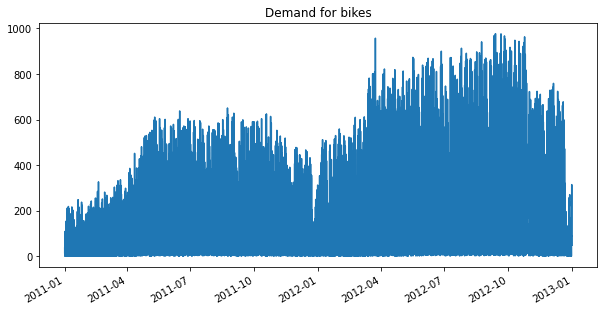

In [215]:
# Test cell for load_data
bike_datafile = "2011-2012_bikes.csv"
weather_datafile = "2011-2012_weather_messy.csv"
bike_data = pd.read_csv(bike_datafile)
weather_data = pd.read_csv(weather_datafile)
    
df = load_data(bike_data,weather_data)
display(df.head())
assert df.shape == (17379,6)
assert type(df.index)==pd.core.indexes.datetimes.DatetimeIndex
assert set(df.columns) == set(['cnt','weathersit','temp','atemp','hum','windspeed'])

plt.figure(figsize=(10,5))
df['cnt'].plot()
plt.title('Demand for bikes')
plt.show()

Now that we've got our data loaded and organized, let's do some clean up.  As we can see when we run the cell below, we have some missing values that we will need to fill.

In [216]:
# Check for null values
df.isna().sum()

cnt            0
weathersit     0
temp          30
atemp         17
hum            6
windspeed      7
dtype: int64

### Question 2
Complete the below function `fill_missing()` which fills in the missing data in our dataframe (all columns) using a forward-fill method from the last previously recorded values of each feature, and then returns the dataframe with all missing values filled.

In [217]:
def fill_missing(data):
    # YOUR CODE HERE
    data.fillna(method='ffill',inplace=True)
    return(data)
    raise NotImplementedError()

In [218]:
# Test cell for remove_nulls()
df_clean = fill_missing(df.copy())

assert df_clean.isna().sum().sum() == 0

### Question 3
We now need to identify and deal with any outliers in our data.  Complete the below function `correct_outliers()` which takes the following inputs:  
- the dataframe output from `fill_missing`. 
- a list of columns to check for outliers (`cols_to_check`), which will contain our continuous features. 
- the `k` value to use in the IQR method to check for outliers  

Your function should use the IQR method we covered in class to check for outliers above the upper threshold (`q75 + k * iqr`) or below the lower threshold (`q25 - k * iqr`).  You should replace the outliers with the last previously recorded value from the columns which is not an outlier (Hint: one way to do this is to replace the outlier values you find with `None` and then apply your `fill_missing()` function from above again to fill the gaps).

The function should return the dataframe with the outlier values replaced by the last previously recorded values which are not outliers.

In [219]:
def correct_outliers(data,cols_to_check,k):
    # YOUR CODE HERE
    for col in cols_to_check:
      Q1 = data[col].quantile(0.25)
      Q3 = data[col].quantile(0.75)
      IQR = Q3 - Q1
      upper = Q3 + k*IQR
      lower = Q1 - k*IQR
      outlier_indicies = data[col].index[(data[col].values > upper) | (data[col].values < lower)]
      data[col].loc[outlier_indicies] = None
    filled = fill_missing(data)
    return(filled)


    raise NotImplementedError()

In [220]:
# Test cell for correct_outliers()
cols = ['temp','atemp','hum','windspeed']
df_no_outliers = correct_outliers(df_clean.copy(),cols,3)

a = np.std(df_clean,axis=0)
b = np.std(df_no_outliers,axis=0)
count = 0
for col in cols:
    if b[col] < a[col]:
        count+=1
assert count == 2

### Question 4
Now that our data is cleaned up, let's split our data into training and test sets to use in modeling.

NOTE: normally on a real problem we would do this first before handling outliers.  We would then build our method for identifying and handling outliers using the training set only, and apply it to both the training and test sets.  But to keep things simple for this exam we have dealt with outliers first in the entire dataset and then split our data.

Complete the below function `split_data()` which splits the data into the training datasets `X_train, y_train` and the test datasets `X_test, y_test`.  Since this is a time series problem, instead of randomly splitting the data your function should use all data up to and including July 31 2012 as the training set and the data for the period August 1 2012 - December 31 2012 as the test set.

In [221]:
def split_data(data):
    # YOUR CODE HERE
    X_train = df_no_outliers.loc[:'2012-07-31 23:00:00','weathersit':]
    y_train = df_no_outliers.loc[:'2012-07-31 23:00:00','cnt']
    X_test = df_no_outliers.loc['2012-08-01 00:00:00':,'weathersit':]
    y_test = df_no_outliers.loc['2012-08-01 00:00:00':,'cnt']
    return X_train,y_train,X_test,y_test
    raise NotImplementedError()

In [222]:
# Test cell for split_data()
X_train,y_train,X_test,y_test = split_data(df_no_outliers.copy())
assert X_train.shape == (13747,5)
assert len(y_train) == 13747
assert X_test.shape == (3632,5)
assert len(y_test) == 3632

### Question 5
Let's now create a few new features to account for possible seasonality/cyclicality in demand for bicycle rentals.  Complete the below function `create_timeseries_features()` which takes a dataframe of input features (`X_train` and then `X_test`) as input and adds the following features to it (named exactly as stated below):  
- 'hourofday': hour of day, 0 to 23. 
- 'dayofweek': day of week as an integer, 0 to 6. 
- 'month': month of year as an integer, 0 to 11. 
- 'year': year as an integer

Your function should return the input feature dataframe with the original columns and the the above features added, named exactly as stated above.

In [223]:
def create_timeseries_features(X):
    # YOUR CODE HERE
    X['hourofday'] = X.index.hour
    X['dayofweek'] = X.index.dayofweek
    X['month'] = X.index.month
    X['year'] = X.index.year
    return X
    raise NotImplementedError()

In [224]:
# Test cell for create_timeseries_features()
X_train_full = create_timeseries_features(X_train.copy())
X_test_full = create_timeseries_features(X_test.copy())
display(X_train.head())

assert set(X_train_full.columns) == set(['weathersit','temp','atemp','hum','windspeed','hourofday','dayofweek','month','year'])
assert X_train_full['hourofday'].nunique()==24
assert X_train_full['dayofweek'].nunique()==7
assert X_train_full['month'].nunique()==12
assert X_train_full['year'].nunique()==2

,weathersit,temp,atemp,hum,windspeed
2011-01-01 00:00:00,1,3.28,3.00,81.00,0.00
2011-01-01 01:00:00,1,2.34,2.00,80.00,0.00
2011-01-01 02:00:00,1,2.34,2.00,80.00,0.00
2011-01-01 03:00:00,1,3.28,3.00,75.00,0.00
2011-01-01 04:00:00,1,3.28,3.00,75.00,0.00


### Question 6
Let's now evaluate whether our continuous weather features have any value in predicting bike demand.  Complete the below function `cont_feat_select()` which takes the training data (X_train_full,y_train) and the list of continuous features as input.  The function should perform a univariate test on the features listed in the input list `feats` using `SelectKBest`.  You should use `f_regression` as the scoring function (which evaluates features based on correlation with the numerical target).  Your function should create and return a dataframe containing two columns:   
- `Feature` should contain the name of each continuous feature  
- `Score` should contain each feature's corresponding f-score on the univariate test

The rows of your dataframe should be sorted by `Score` with the features with the largest scores first.

In [225]:
def cont_feat_select(X,y,feats):
    # YOUR CODE HERE
    ftest = SelectKBest(score_func=f_regression, k='all')
    ftest.fit(X[feats],y)
    f_scores = pd.DataFrame(ftest.scores_)
    dfcolumns = pd.DataFrame(feats)
    f_scores = pd.concat([dfcolumns,f_scores],axis=1)
    f_scores.columns = ['Feature','Score']  
    f_scores = f_scores.sort_values(by='Score',ascending=False)
    return f_scores
    raise NotImplementedError()

,Feature,Score
0,temp,"3,087.29"
1,atemp,"3,013.72"
2,hum,"1,660.16"
3,windspeed,141.17


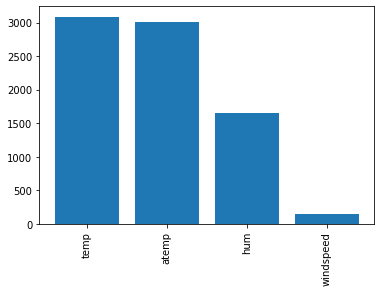

In [226]:
# Test cell for cont_feat_select()
cont_feats = ['temp','atemp','hum','windspeed']
f_scores = cont_feat_select(X_train_full,y_train,cont_feats)
display(f_scores)

assert f_scores.shape==(4,2)
for col in ['Feature','Score']:
    assert col in f_scores.columns
    
assert f_scores['Score'][0]>=f_scores['Score'][1]

# Plot scores
plt.bar(x=f_scores['Feature'],height=f_scores['Score'])
plt.xticks(rotation=90)
plt.show()

### Question 7
Let's now drop the lowest scoring continuous feature, based on our univariate test above.  Complete the below function `drop_lowest_feat()` which takes as input the X_train_full and X_test_full dataframes and your feature scoring dataframe output from your `cont_feat_select()` function above.  Your function should identify the lowest performing feature from your `f_scores` dataframe and drop it from both X_train_full and X_test_full.  It should then return the X_train_full and X_test_full dataframes with the feature dropped.

In [227]:
def drop_lowest_feat(X_train,X_test,scores_df):
    # YOUR CODE HERE
    lowest_feat = scores_df['Feature'].iloc[-1]
    X_train.drop(columns=lowest_feat, inplace=True)
    X_test.drop(columns=lowest_feat, inplace=True)
    return X_train, X_test
    raise NotImplementedError()

In [228]:
# Test cell for drop_lowest_feat()
X_train_reduced,X_test_reduced = drop_lowest_feat(X_train_full.copy(),X_test_full.copy(),f_scores)
display(X_train_reduced.head())

assert X_train_reduced.shape==(13747, 8)
assert X_test_reduced.shape==(3632, 8)

,weathersit,temp,atemp,hum,hourofday,dayofweek,month,year
2011-01-01 00:00:00,1,3.28,3.00,81.00,0,5,1,2011
2011-01-01 01:00:00,1,2.34,2.00,80.00,1,5,1,2011
2011-01-01 02:00:00,1,2.34,2.00,80.00,2,5,1,2011
2011-01-01 03:00:00,1,3.28,3.00,75.00,3,5,1,2011
2011-01-01 04:00:00,1,3.28,3.00,75.00,4,5,1,2011


### Question 8
We now need to encode our categorical features to prepare them for use in modeling.  Complete the below function `encode_training()` which takes the training data `X_train_reduced` and the list of categorical features (`catfeats`) as inputs. The function should use `OneHotEncoder(handle_unknown='ignore')` to one-hot encode the categorical features in the training dataframe (make sure to drop the original categorical columns after one-hot encoding them).  Your function should return the `X_train_reduced` dataframe with the categorical columns listed in `catfeats` one-hot encoded, and the one-hot encoder object (which we will use later to encode the test set).

In [229]:
def encode_training(X,catfeats):
    # YOUR CODE HERE
    # Apply onehot encoder
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    onehot_enc.fit(X[catfeats])
    colnames = columns=list(onehot_enc.get_feature_names(input_features=catfeats))
    onehot_vals = onehot_enc.transform(X[catfeats]).toarray()
    # Put transformed data into a dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(catfeats,axis=1)
    return X, onehot_enc
    raise NotImplementedError()

In [230]:
# Test cell for encode_training()
cat_feats = ['hourofday','weathersit','dayofweek','month','year']

X_train_encoded,onehot_enc = encode_training(X_train_reduced.copy(),cat_feats)

for col in cat_feats:
    assert col not in X_train_encoded.columns
    
assert X_train_encoded.shape==(13747,52)

### Question 8
We can now use our encoder to encode the test set.  Complete the below function `encode_test()` which takes the test set `X_test_reduced`, the list of categorical features (`catfeats`) and the one-hot encoder object `onehot_enc` as inputs.  The function should use the encoder to one-hot encode X_test (be sure to drop the original categorical columns from the dataframe after one-hot encoding them).  Your function should return the X_test dataframe with ther categorical columns one-hot encoded.

In [231]:
def encode_test(X,catfeats,encoder):
    # YOUR CODE HERE
    # Apply onehot encoder
    colnames = columns=list(encoder.get_feature_names(input_features=catfeats))
    onehot_vals = encoder.transform(X[catfeats]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(catfeats,axis=1)
    return X
    raise NotImplementedError()

In [232]:
# Test cell for encode_test()
X_test_encoded = encode_test(X_test_reduced.copy(),cat_feats,onehot_enc)
    
for col in cat_feats:
    assert col not in X_test_encoded.columns
    
assert X_test_encoded.shape==(3632,52)

### Question 9
Finally, let's standardize our continuous features before we run our model.  Complete the below function `scale_cont_feats()` which takes the X_train and X_test dataframes as input and a list of the continuous features (`feats`) to standardize.  Your function should use `StandardScaler()` to standardize the continuous features (or do so manually if you prefer) and return the X_train and X_test dataframes with the continuous features (listed in the `feats` input list) standardized.

In [233]:
def scale_cont_feats(X_train,X_test,feats):
    # YOUR CODE HERE
    X_train_mu = X_train[feats].mean(axis=0)
    X_train_stdev = X_train[feats].std(axis=0)
    X_test_mu = X_test[feats].mean(axis=0)
    X_test_stdev = X_test[feats].std(axis=0)

    # Calculate the standardized data
    X_train[feats] = (X_train[feats]-X_train_mu) / X_train_stdev
    X_test[feats] = (X_test[feats]-X_train_mu) / X_test_stdev

    return X_train, X_test
    raise NotImplementedError()

In [234]:
# Test cell for scale_cont_feats
feats = [col for col in list(X_train_reduced.columns) if col not in cat_feats]
X_train_final,X_test_final = scale_cont_feats(X_train_encoded.copy(),X_test_encoded.copy(),feats)

for feat in feats:
    assert np.round(np.mean(X_train_final.loc[:,feat]),1)==0
    assert np.round(np.mean(X_test_final.loc[:,feat]),5)!=0

Now that we've prepared our features we are ready to run our model.  Run the cell below, which trains the model on the training set and calculates and reports the mean squared error (MSE) on the test set.  If everything went well you should have a MSE below 18500

In [235]:
mse_score = run_model(X_train_final,y_train,X_test_final,y_test)
print('Mean Squared Error on the test set: {:.2f}'.format(mse_score))

assert mse_score < 18500

Mean Squared Error on the test set: 18087.76


### The End
Congratulations on finishing the exam, and we hope you enjoyed the course!